In [2]:
!pip install pandas

  Using cached pandas-2.3.3-cp39-cp39-win_amd64.whl (11.4 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


You should consider upgrading via the 'C:\Users\fridm\Desktop\GraphPropertyPredict\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install seaborn

In [3]:
import pandas as pd

In [ ]:
df = pd.read_csv(r"C:\Users\fridm\Desktop\GraphPropertyPredict\out_dataset\ordering_dataset.csv")

In [ ]:
df['colorIsLessThanTwo'] = df['best_k'].apply(lambda x: x <= 2)
# transform into 0 or 1 from binary
df['colorIsLessThanTwo'] = df['colorIsLessThanTwo'].apply(lambda x: 1 if x else 0)

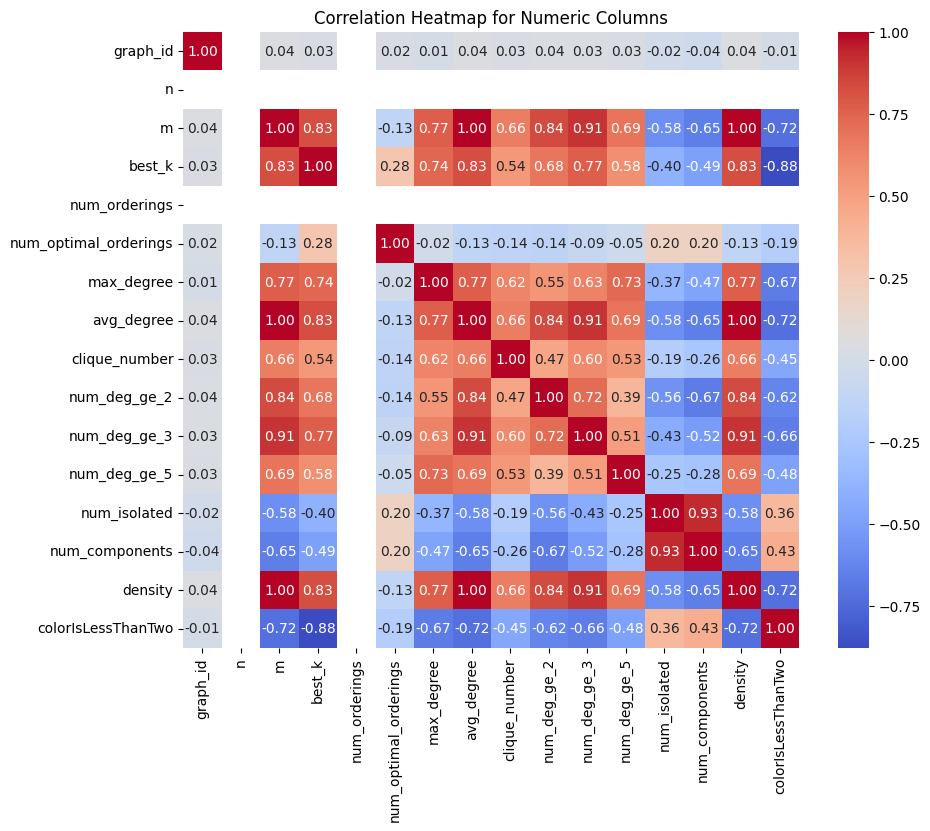

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.select_dtypes(include=['number']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()


In [16]:
# JUPYTER NOTEBOOK CELL — feature engineering (100+ numeric graph characteristics)
# Assumes your CSV has at least: graph_id, n, m, edges, best_k (edges is a JSON list of [u,v] pairs)

import json
import math
import numpy as np
import pandas as pd
import networkx as nx

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None


# -----------------------------
# small numeric helpers
# -----------------------------
def _safe_float(x, default=np.nan):
    try:
        if x is None:
            return default
        return float(x)
    except Exception:
        return default

def _safe_div(a, b, default=np.nan):
    return default if b == 0 else (a / b)

def _skew(x):
    x = np.asarray(x, dtype=float)
    if len(x) < 3:
        return np.nan
    m = x.mean()
    s = x.std(ddof=0)
    if s == 0:
        return 0.0
    return float(np.mean(((x - m) / s) ** 3))

def _kurtosis_excess(x):
    x = np.asarray(x, dtype=float)
    if len(x) < 4:
        return np.nan
    m = x.mean()
    s = x.std(ddof=0)
    if s == 0:
        return 0.0
    return float(np.mean(((x - m) / s) ** 4) - 3.0)

def _gini(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return np.nan
    if np.allclose(x, 0):
        return 0.0
    x = np.sort(np.maximum(x, 0))
    n = len(x)
    cumx = np.cumsum(x)
    return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

def _entropy_counts(counts):
    counts = np.asarray(counts, dtype=float)
    s = counts.sum()
    if s <= 0:
        return np.nan
    p = counts / s
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

def _summarize_vector(values, prefix):
    """Return many stats -> many columns."""
    v = np.asarray(list(values), dtype=float)
    out = {}
    out[f"{prefix}__count"] = float(len(v))
    if len(v) == 0:
        for k in ["min","max","mean","std","var","median","q10","q25","q75","q90","skew","kurtosis_excess","gini","entropy"]:
            out[f"{prefix}__{k}"] = np.nan
        return out

    out[f"{prefix}__min"] = float(np.min(v))
    out[f"{prefix}__max"] = float(np.max(v))
    out[f"{prefix}__mean"] = float(np.mean(v))
    out[f"{prefix}__std"] = float(np.std(v, ddof=0))
    out[f"{prefix}__var"] = float(np.var(v, ddof=0))
    out[f"{prefix}__median"] = float(np.median(v))
    out[f"{prefix}__q10"] = float(np.quantile(v, 0.10))
    out[f"{prefix}__q25"] = float(np.quantile(v, 0.25))
    out[f"{prefix}__q75"] = float(np.quantile(v, 0.75))
    out[f"{prefix}__q90"] = float(np.quantile(v, 0.90))
    out[f"{prefix}__skew"] = _skew(v)
    out[f"{prefix}__kurtosis_excess"] = _kurtosis_excess(v)
    out[f"{prefix}__gini"] = _gini(v)

    # entropy for binned values (robust, always numeric)
    if np.all(np.isfinite(v)) and len(v) > 1 and np.max(v) > np.min(v):
        hist, _ = np.histogram(v, bins=min(10, len(v)))
        out[f"{prefix}__entropy"] = _entropy_counts(hist)
    else:
        out[f"{prefix}__entropy"] = np.nan
    return out


# -----------------------------
# cycles: enumerate UNIQUE simple cycles in undirected graph (small n)
# -----------------------------
def _canonical_cycle(nodes):
    """nodes: list of ints in order around a directed cycle. Return canonical tuple for undirected cycle."""
    cyc = list(nodes)
    m = min(cyc)
    i = cyc.index(m)
    rot = cyc[i:] + cyc[:i]
    rev = list(reversed(cyc))
    i2 = rev.index(m)
    rot2 = rev[i2:] + rev[:i2]
    t1, t2 = tuple(rot), tuple(rot2)
    return t1 if t1 < t2 else t2

def undirected_simple_cycles_unique(G):
    """Returns list of canonical cycles (as tuples). Uses DiGraph + nx.simple_cycles; OK for n<=~12."""
    if G.number_of_edges() == 0 or G.number_of_nodes() < 3:
        return []
    D = nx.DiGraph()
    D.add_nodes_from(G.nodes())
    D.add_edges_from((u, v) for u, v in G.edges())
    D.add_edges_from((v, u) for u, v in G.edges())
    cycset = set()
    for cyc in nx.simple_cycles(D):
        if len(cyc) >= 3:
            cycset.add(_canonical_cycle(cyc))
    return sorted(cycset, key=lambda t: (len(t), t))


# -----------------------------
# exact-ish expensive features (fine for n=8)
# -----------------------------
def exact_independence_number(G):
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return 0
    best = 0
    # brute force over subsets
    for mask in range(1 << n):
        k = mask.bit_count()
        if k <= best:
            continue
        S = [nodes[i] for i in range(n) if (mask >> i) & 1]
        H = G.subgraph(S)
        if H.number_of_edges() == 0:
            best = k
    return best

def count_independent_sets(G):
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return 1
    cnt = 0
    for mask in range(1 << n):
        S = [nodes[i] for i in range(n) if (mask >> i) & 1]
        if G.subgraph(S).number_of_edges() == 0:
            cnt += 1
    return cnt

def exact_min_dominating_set_size(G):
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return 0
    # increasing size
    for k in range(1, n + 1):
        # combinations via masks
        for mask in range(1 << n):
            if mask.bit_count() != k:
                continue
            S = {nodes[i] for i in range(n) if (mask >> i) & 1}
            dominated = set(S)
            for v in S:
                dominated.update(G.neighbors(v))
            if len(dominated) == n:
                return k
    return n

def exact_min_feedback_vertex_set_size(G):
    """Minimum vertices to remove to make graph acyclic (forest)."""
    nodes = list(G.nodes())
    n = len(nodes)
    if n <= 2:
        return 0
    if nx.is_forest(G):
        return 0
    for k in range(1, n + 1):
        for mask in range(1 << n):
            if mask.bit_count() != k:
                continue
            rem = {nodes[i] for i in range(n) if (mask >> i) & 1}
            H = G.copy()
            H.remove_nodes_from(rem)
            if nx.is_forest(H):
                return k
    return n

def exact_chromatic_number_dsatur(G):
    """Small-graph exact chromatic number via DSATUR branch & bound."""
    nodes = list(G.nodes())
    if not nodes:
        return 0
    if G.number_of_edges() == 0:
        return 1

    # initial greedy UB
    order = sorted(nodes, key=lambda v: G.degree(v), reverse=True)
    greedy = {}
    for v in order:
        used = {greedy[u] for u in G.neighbors(v) if u in greedy}
        c = 1
        while c in used:
            c += 1
        greedy[v] = c
    best_k = max(greedy.values())

    adj = {v: set(G.neighbors(v)) for v in nodes}
    colors = {}
    neighbor_colors = {v: set() for v in nodes}
    uncolored = set(nodes)

    def pick():
        return max(uncolored, key=lambda v: (len(neighbor_colors[v]), len(adj[v])))

    def backtrack(current_max):
        nonlocal best_k
        if not uncolored:
            best_k = min(best_k, current_max)
            return
        if current_max >= best_k:
            return

        v = pick()
        uncolored.remove(v)
        forbidden = {colors[u] for u in adj[v] if u in colors}

        for c in range(1, current_max + 1):
            if c in forbidden:
                continue
            colors[v] = c
            changed = []
            for u in adj[v]:
                if u in uncolored and c not in neighbor_colors[u]:
                    neighbor_colors[u].add(c)
                    changed.append(u)
            backtrack(current_max)
            for u in changed:
                neighbor_colors[u].remove(c)
            del colors[v]

        new_c = current_max + 1
        if new_c < best_k:
            colors[v] = new_c
            changed = []
            for u in adj[v]:
                if u in uncolored and new_c not in neighbor_colors[u]:
                    neighbor_colors[u].add(new_c)
                    changed.append(u)
            backtrack(new_c)
            for u in changed:
                neighbor_colors[u].remove(new_c)
            del colors[v]

        uncolored.add(v)

    backtrack(0)
    return int(best_k)


# -----------------------------
# feature extraction
# -----------------------------
def graph_features(G, max_n_for_expensive=12):
    f = {}

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # basics
    f["basic__n"] = float(n)
    f["basic__m"] = float(m)
    f["basic__density"] = float(nx.density(G) if n > 1 else 0.0)
    f["basic__is_connected"] = float(1.0 if (n <= 1 or nx.is_connected(G)) else 0.0)
    f["basic__num_components"] = float(nx.number_connected_components(G) if n > 0 else 0.0)

    comp_sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True) if n > 0 else []
    f["components__largest_size"] = float(comp_sizes[0]) if comp_sizes else 0.0
    f["components__largest_fraction"] = float(_safe_div(comp_sizes[0], n, 0.0)) if comp_sizes else 0.0
    f["components__size_entropy"] = _entropy_counts(comp_sizes) if comp_sizes else np.nan

    # degrees
    deg = np.array([d for _, d in G.degree()], dtype=float)
    f.update(_summarize_vector(deg, "degree"))
    f["degree__num_isolated"] = float(np.sum(deg == 0))
    for k in range(1, 8):
        f[f"degree__num_ge_{k}"] = float(np.sum(deg >= k))
    # degree histogram entropy
    if n > 0:
        vals, counts = np.unique(deg.astype(int), return_counts=True)
        f["degree__pmf_entropy"] = _entropy_counts(counts)
    else:
        f["degree__pmf_entropy"] = np.nan

    # assortativity (can be nan for tiny graphs)
    try:
        f["degree__assortativity"] = _safe_float(nx.degree_assortativity_coefficient(G))
    except Exception:
        f["degree__assortativity"] = np.nan

    # clustering / triangles / wedges
    try:
        clustering = nx.clustering(G)
        cvals = list(clustering.values())
        f.update(_summarize_vector(cvals, "clustering_node"))
        f["clustering__average"] = _safe_float(nx.average_clustering(G))
        f["clustering__transitivity"] = _safe_float(nx.transitivity(G))
    except Exception:
        f["clustering__average"] = np.nan
        f["clustering__transitivity"] = np.nan
        f.update(_summarize_vector([], "clustering_node"))

    # triangles count (consistent)
    if n > 0:
        tri = sum(nx.triangles(G).values()) / 3.0
    else:
        tri = 0.0
    f["triangles__count"] = float(tri)

    wedges = float(np.sum(deg * (deg - 1) / 2.0))  # connected triples at a node (unordered)
    f["wedges__count"] = wedges
    f["wedges__open_wedges_est"] = float(max(0.0, wedges - 3.0 * tri))
    f["triangles__to_wedges_ratio"] = float(_safe_div(tri, wedges, 0.0))

    # squares (optional; square_clustering gives per-node squares-based metric)
    try:
        sq = nx.square_clustering(G)
        f.update(_summarize_vector(sq.values(), "square_clustering_node"))
    except Exception:
        f.update(_summarize_vector([], "square_clustering_node"))

    # shortest path stats (weighted across components) + efficiency
    # compute all-pairs shortest paths for small n
    if n <= 1:
        f["dist__avg_shortest_path_connected_pairs"] = 0.0
        f["dist__global_efficiency"] = 0.0
        f["dist__reachable_pair_fraction"] = 1.0
        f["ecc__diameter_lcc"] = 0.0
        f["ecc__radius_lcc"] = 0.0
        f.update(_summarize_vector([0.0], "ecc_node_lcc"))
    else:
        dists = []
        inv_dists = []
        reachable = 0
        total_pairs = n * (n - 1) / 2
        # all pairs lengths per component
        for comp in nx.connected_components(G):
            H = G.subgraph(comp)
            lengths = dict(nx.all_pairs_shortest_path_length(H))
            comp_nodes = list(H.nodes())
            for i in range(len(comp_nodes)):
                u = comp_nodes[i]
                for j in range(i + 1, len(comp_nodes)):
                    v = comp_nodes[j]
                    d = lengths[u][v]
                    dists.append(d)
                    inv_dists.append(1.0 / d if d > 0 else 0.0)
                    reachable += 1

        f["dist__reachable_pair_fraction"] = float(_safe_div(reachable, total_pairs, 0.0))
        f["dist__avg_shortest_path_connected_pairs"] = float(np.mean(dists)) if dists else np.nan
        f["dist__global_efficiency"] = float(np.mean(inv_dists)) if inv_dists else 0.0

        # eccentricity stats on largest connected component
        lcc_nodes = max(nx.connected_components(G), key=len)
        L = G.subgraph(lcc_nodes).copy()
        try:
            ecc = nx.eccentricity(L)
            ecc_vals = list(ecc.values())
            f.update(_summarize_vector(ecc_vals, "ecc_node_lcc"))
            f["ecc__diameter_lcc"] = float(nx.diameter(L)) if L.number_of_nodes() > 0 else 0.0
            f["ecc__radius_lcc"] = float(nx.radius(L)) if L.number_of_nodes() > 0 else 0.0
        except Exception:
            f.update(_summarize_vector([], "ecc_node_lcc"))
            f["ecc__diameter_lcc"] = np.nan
            f["ecc__radius_lcc"] = np.nan

    # biconnectivity / bridges / articulation
    try:
        f["cut__num_bridges"] = float(len(list(nx.bridges(G))))
    except Exception:
        f["cut__num_bridges"] = np.nan
    try:
        f["cut__num_articulation_points"] = float(len(list(nx.articulation_points(G))))
    except Exception:
        f["cut__num_articulation_points"] = np.nan

    try:
        bcc = list(nx.biconnected_components(G))
        bcc_sizes = [len(c) for c in bcc]
        f["biconnected__count"] = float(len(bcc))
        f.update(_summarize_vector(bcc_sizes, "biconnected_sizes"))
    except Exception:
        f["biconnected__count"] = np.nan
        f.update(_summarize_vector([], "biconnected_sizes"))

    # connectivity
    try:
        f["connectivity__node_connectivity"] = _safe_float(nx.node_connectivity(G))
    except Exception:
        f["connectivity__node_connectivity"] = np.nan
    try:
        f["connectivity__edge_connectivity"] = _safe_float(nx.edge_connectivity(G))
    except Exception:
        f["connectivity__edge_connectivity"] = np.nan
    try:
        if n > 1 and (nx.is_connected(G)):
            cut_value, _ = nx.stoer_wagner(G)  # global min-cut
            f["connectivity__global_mincut_size"] = float(cut_value)
        else:
            f["connectivity__global_mincut_size"] = 0.0
    except Exception:
        f["connectivity__global_mincut_size"] = np.nan

    # core / degeneracy
    try:
        core = nx.core_number(G) if n > 0 else {}
        core_vals = list(core.values()) if core else []
        f.update(_summarize_vector(core_vals, "core_number_node"))
        f["core__degeneracy"] = float(max(core_vals)) if core_vals else 0.0
        # edges/nodes in 2-core
        if core:
            nodes_2core = [v for v, c in core.items() if c >= 2]
            H2 = G.subgraph(nodes_2core)
            f["core__n_in_2core"] = float(H2.number_of_nodes())
            f["core__m_in_2core"] = float(H2.number_of_edges())
            f["core__density_2core"] = float(nx.density(H2) if H2.number_of_nodes() > 1 else 0.0)
        else:
            f["core__n_in_2core"] = 0.0
            f["core__m_in_2core"] = 0.0
            f["core__density_2core"] = 0.0
    except Exception:
        f.update(_summarize_vector([], "core_number_node"))
        f["core__degeneracy"] = np.nan
        f["core__n_in_2core"] = np.nan
        f["core__m_in_2core"] = np.nan
        f["core__density_2core"] = np.nan

    # clique counts (all sizes) + maximal cliques
    try:
        clique_counts = {k: 0 for k in range(1, n + 1)}
        maximal_sizes = []
        for clq in nx.enumerate_all_cliques(G):
            clique_counts[len(clq)] += 1
        for clq in nx.find_cliques(G):
            maximal_sizes.append(len(clq))
        for k in range(1, min(n, 8) + 1):
            f[f"cliques__count_size_{k}"] = float(clique_counts.get(k, 0))
        f["cliques__num_maximal_cliques"] = float(len(maximal_sizes))
        f.update(_summarize_vector(maximal_sizes, "cliques__maximal_size"))
        f["cliques__clique_number"] = float(max(maximal_sizes)) if maximal_sizes else (1.0 if n > 0 else 0.0)
    except Exception:
        for k in range(1, 9):
            f[f"cliques__count_size_{k}"] = np.nan
        f["cliques__num_maximal_cliques"] = np.nan
        f.update(_summarize_vector([], "cliques__maximal_size"))
        f["cliques__clique_number"] = np.nan

    # simple boolean-ish structure
    f["structure__is_tree"] = float(1.0 if (n > 0 and nx.is_tree(G)) else 0.0)
    f["structure__is_forest"] = float(1.0 if nx.is_forest(G) else 0.0)
    try:
        f["structure__is_bipartite"] = float(1.0 if nx.is_bipartite(G) else 0.0)
    except Exception:
        f["structure__is_bipartite"] = np.nan
    try:
        f["structure__is_chordal"] = float(1.0 if nx.is_chordal(G) else 0.0)
    except Exception:
        f["structure__is_chordal"] = np.nan
    try:
        f["structure__is_planar"] = float(1.0 if nx.check_planarity(G, counterexample=False)[0] else 0.0)
    except Exception:
        f["structure__is_planar"] = np.nan
    f["structure__is_regular"] = float(1.0 if (n > 0 and len(set(deg.astype(int))) == 1) else 0.0)
    f["structure__is_complete"] = float(1.0 if (n > 0 and m == n * (n - 1) / 2) else 0.0)

    # cycle space / cycles
    # cyclomatic number = m - n + components (dimension of cycle space)
    f["cycles__cycle_rank"] = float(m - n + int(f["basic__num_components"])) if n > 0 else 0.0
    try:
        basis = nx.cycle_basis(G)
        basis_lens = [len(c) for c in basis]
        f["cycles__cycle_basis_count"] = float(len(basis_lens))
        f.update(_summarize_vector(basis_lens, "cycles__cycle_basis_len"))
    except Exception:
        f["cycles__cycle_basis_count"] = np.nan
        f.update(_summarize_vector([], "cycles__cycle_basis_len"))

    # enumerate all simple cycles (small n)
    if n <= max_n_for_expensive:
        try:
            cycles = undirected_simple_cycles_unique(G)
            f["cycles__simple_cycles_total"] = float(len(cycles))
            # length histogram
            for k in range(3, min(n, 10) + 1):
                f[f"cycles__simple_cycles_len_{k}"] = float(sum(1 for c in cycles if len(c) == k))

            # chordiness + overlap: “cycles within cycles” style signals
            chord_counts = []
            chorded = 0
            node_in_cycles = {v: 0 for v in G.nodes()}
            edge_in_cycles = {tuple(sorted(e)): 0 for e in G.edges()}
            for cyc in cycles:
                cyc_nodes = set(cyc)
                H = G.subgraph(cyc_nodes)
                L = len(cyc)
                # edges in a simple cycle is L; extra edges among those nodes are “chords”
                chords = H.number_of_edges() - L
                chord_counts.append(chords)
                if chords > 0:
                    chorded += 1
                for v in cyc_nodes:
                    node_in_cycles[v] += 1
                # count cycle edges (undirected) from consecutive nodes
                for i in range(L):
                    a, b = cyc[i], cyc[(i + 1) % L]
                    e = tuple(sorted((a, b)))
                    if e in edge_in_cycles:
                        edge_in_cycles[e] += 1

            f["cycles__chorded_cycles_count"] = float(chorded)
            f["cycles__chorded_cycles_fraction"] = float(_safe_div(chorded, max(1, len(cycles)), 0.0))
            f.update(_summarize_vector(chord_counts, "cycles__chords_per_cycle"))
            f.update(_summarize_vector(node_in_cycles.values(), "cycles__cycles_per_node"))
            f.update(_summarize_vector(edge_in_cycles.values(), "cycles__cycles_per_edge"))

            # cycle intersection graph (cycles intersect by >=1 node)
            if len(cycles) >= 2:
                CIG = nx.Graph()
                CIG.add_nodes_from(range(len(cycles)))
                cycsets = [set(c) for c in cycles]
                for i in range(len(cycles)):
                    for j in range(i + 1, len(cycles)):
                        if cycsets[i].intersection(cycsets[j]):
                            CIG.add_edge(i, j)
                f["cycles__intersection_edges"] = float(CIG.number_of_edges())
                f["cycles__intersection_density"] = float(nx.density(CIG) if CIG.number_of_nodes() > 1 else 0.0)
                cig_deg = [d for _, d in CIG.degree()]
                f.update(_summarize_vector(cig_deg, "cycles__intersection_degree"))
                f["cycles__intersection_components"] = float(nx.number_connected_components(CIG))
            else:
                f["cycles__intersection_edges"] = 0.0
                f["cycles__intersection_density"] = 0.0
                f.update(_summarize_vector([], "cycles__intersection_degree"))
                f["cycles__intersection_components"] = 0.0
        except Exception:
            f["cycles__simple_cycles_total"] = np.nan
            for k in range(3, 11):
                f[f"cycles__simple_cycles_len_{k}"] = np.nan
            f["cycles__chorded_cycles_count"] = np.nan
            f["cycles__chorded_cycles_fraction"] = np.nan
            f.update(_summarize_vector([], "cycles__chords_per_cycle"))
            f.update(_summarize_vector([], "cycles__cycles_per_node"))
            f.update(_summarize_vector([], "cycles__cycles_per_edge"))
            f["cycles__intersection_edges"] = np.nan
            f["cycles__intersection_density"] = np.nan
            f.update(_summarize_vector([], "cycles__intersection_degree"))
            f["cycles__intersection_components"] = np.nan
    else:
        f["cycles__simple_cycles_total"] = np.nan
        for k in range(3, 11):
            f[f"cycles__simple_cycles_len_{k}"] = np.nan
        f["cycles__chorded_cycles_count"] = np.nan
        f["cycles__chorded_cycles_fraction"] = np.nan
        f.update(_summarize_vector([], "cycles__chords_per_cycle"))
        f.update(_summarize_vector([], "cycles__cycles_per_node"))
        f.update(_summarize_vector([], "cycles__cycles_per_edge"))
        f["cycles__intersection_edges"] = np.nan
        f["cycles__intersection_density"] = np.nan
        f.update(_summarize_vector([], "cycles__intersection_degree"))
        f["cycles__intersection_components"] = np.nan

    # spanning trees (Kirchhoff; 0 if disconnected)
    try:
        if n == 0:
            f["trees__spanning_tree_count"] = 0.0
            f["trees__log_spanning_tree_count"] = 0.0
        elif not nx.is_connected(G):
            f["trees__spanning_tree_count"] = 0.0
            f["trees__log_spanning_tree_count"] = -np.inf
        else:
            L = nx.laplacian_matrix(G).toarray().astype(float)
            # delete last row/col
            M = L[:-1, :-1]
            det = float(round(np.linalg.det(M)))
            det = max(det, 0.0)
            f["trees__spanning_tree_count"] = det
            f["trees__log_spanning_tree_count"] = float(np.log(det)) if det > 0 else -np.inf
    except Exception:
        f["trees__spanning_tree_count"] = np.nan
        f["trees__log_spanning_tree_count"] = np.nan

    # spectral features (adjacency + laplacian)
    try:
        A = nx.to_numpy_array(G, dtype=float)
        eigA = np.linalg.eigvalsh(A)  # sorted asc
        eigA_sorted = np.sort(eigA)[::-1]  # desc
        f["spectralA__spectral_radius"] = float(eigA_sorted[0]) if len(eigA_sorted) else 0.0
        f["spectralA__second_largest_eig"] = float(eigA_sorted[1]) if len(eigA_sorted) > 1 else np.nan
        f["spectralA__smallest_eig"] = float(eigA_sorted[-1]) if len(eigA_sorted) else 0.0
        f["spectralA__spectral_gap_12"] = float(eigA_sorted[0] - eigA_sorted[1]) if len(eigA_sorted) > 1 else np.nan
        f["spectralA__energy"] = float(np.sum(np.abs(eigA)))
        f["spectralA__estrada_index"] = float(np.sum(np.exp(eigA)))
        f["spectralA__num_zero_eigs"] = float(np.sum(np.isclose(eigA, 0.0, atol=1e-9)))

        L = nx.laplacian_matrix(G).toarray().astype(float)
        eigL = np.linalg.eigvalsh(L)  # asc
        f["spectralL__algebraic_connectivity"] = float(eigL[1]) if len(eigL) > 1 else np.nan
        f["spectralL__largest_eig"] = float(eigL[-1]) if len(eigL) else 0.0
        f["spectralL__trace"] = float(np.trace(L))  # = 2m
        f["spectralL__num_zero_eigs"] = float(np.sum(np.isclose(eigL, 0.0, atol=1e-9)))

        # Kirchhoff index (effective resistance) on connected graph: n * sum_{i=2..n} 1/eigL[i]
        if n >= 2 and nx.is_connected(G):
            nonzero = eigL[1:]
            if np.any(np.isclose(nonzero, 0.0)):
                f["spectralL__kirchhoff_index"] = np.nan
            else:
                f["spectralL__kirchhoff_index"] = float(n * np.sum(1.0 / nonzero))
        else:
            f["spectralL__kirchhoff_index"] = np.nan
    except Exception:
        for k in [
            "spectralA__spectral_radius","spectralA__second_largest_eig","spectralA__smallest_eig",
            "spectralA__spectral_gap_12","spectralA__energy","spectralA__estrada_index","spectralA__num_zero_eigs",
            "spectralL__algebraic_connectivity","spectralL__largest_eig","spectralL__trace","spectralL__num_zero_eigs",
            "spectralL__kirchhoff_index"
        ]:
            f[k] = np.nan

    # centralities (node + edge), summarized into many columns
    # NOTE: these are fast for n=8 and often correlate with “hardness”/best_k-like behavior.
    def add_node_centrality(name, values_dict):
        vals = list(values_dict.values()) if isinstance(values_dict, dict) else list(values_dict)
        f.update(_summarize_vector(vals, f"cent_{name}"))

    try:
        add_node_centrality("degree", nx.degree_centrality(G))
    except Exception:
        f.update(_summarize_vector([], "cent_degree"))
    try:
        add_node_centrality("betweenness", nx.betweenness_centrality(G, normalized=True))
    except Exception:
        f.update(_summarize_vector([], "cent_betweenness"))
    try:
        add_node_centrality("closeness", nx.closeness_centrality(G))
    except Exception:
        f.update(_summarize_vector([], "cent_closeness"))
    try:
        add_node_centrality("harmonic", nx.harmonic_centrality(G))
    except Exception:
        f.update(_summarize_vector([], "cent_harmonic"))
    try:
        add_node_centrality("load", nx.load_centrality(G))
    except Exception:
        f.update(_summarize_vector([], "cent_load"))
    try:
        add_node_centrality("pagerank", nx.pagerank(G, alpha=0.85))
    except Exception:
        f.update(_summarize_vector([], "cent_pagerank"))
    try:
        add_node_centrality("eigenvector", nx.eigenvector_centrality_numpy(G))
    except Exception:
        f.update(_summarize_vector([], "cent_eigenvector"))
    try:
        # Katz alpha must be < 1/lambda_max; estimate from spectral radius
        if n > 0 and m > 0:
            A = nx.to_numpy_array(G, dtype=float)
            lam = float(np.max(np.linalg.eigvalsh(A)))
            alpha = 0.9 / lam if lam > 1e-9 else 0.1
            add_node_centrality("katz", nx.katz_centrality_numpy(G, alpha=alpha, beta=1.0))
        else:
            f.update(_summarize_vector([0.0] * max(1, n), "cent_katz"))
    except Exception:
        f.update(_summarize_vector([], "cent_katz"))

    # edge betweenness stats
    try:
        eb = nx.edge_betweenness_centrality(G, normalized=True)
        f.update(_summarize_vector(eb.values(), "edge_betweenness"))
    except Exception:
        f.update(_summarize_vector([], "edge_betweenness"))

    # average neighbor degree stats (degree correlations)
    try:
        andeg = nx.average_neighbor_degree(G)
        f.update(_summarize_vector(andeg.values(), "avg_neighbor_degree_node"))
    except Exception:
        f.update(_summarize_vector([], "avg_neighbor_degree_node"))

    # greedy colorings as cheap proxies (multiple ordering strategies)
    try:
        strat_map = {
            "largest_first": "greedy_coloring__largest_first",
            "random_sequential": "greedy_coloring__random_sequential",
            "smallest_last": "greedy_coloring__smallest_last",
            "connected_sequential_bfs": "greedy_coloring__bfs",
            "connected_sequential_dfs": "greedy_coloring__dfs",
            "saturation_largest_first": "greedy_coloring__dsatur",
        }
        for strat, colname in strat_map.items():
            col = nx.coloring.greedy_color(G, strategy=strat)
            k = (max(col.values()) + 1) if col else 0
            f[colname] = float(k)
    except Exception:
        for colname in [
            "greedy_coloring__largest_first","greedy_coloring__random_sequential","greedy_coloring__smallest_last",
            "greedy_coloring__bfs","greedy_coloring__dfs","greedy_coloring__dsatur"
        ]:
            f[colname] = np.nan

    # complement + line graph quick features (adds “another view”)
    try:
        GC = nx.complement(G)
        f["complement__m"] = float(GC.number_of_edges())
        f["complement__density"] = float(nx.density(GC) if n > 1 else 0.0)
        triC = sum(nx.triangles(GC).values()) / 3.0 if n > 0 else 0.0
        f["complement__triangles"] = float(triC)
    except Exception:
        f["complement__m"] = np.nan
        f["complement__density"] = np.nan
        f["complement__triangles"] = np.nan

    try:
        LG = nx.line_graph(G)
        f["line_graph__n"] = float(LG.number_of_nodes())
        f["line_graph__m"] = float(LG.number_of_edges())
        f["line_graph__density"] = float(nx.density(LG) if LG.number_of_nodes() > 1 else 0.0)
        lg_deg = [d for _, d in LG.degree()]
        f.update(_summarize_vector(lg_deg, "line_graph__degree"))
    except Exception:
        f["line_graph__n"] = np.nan
        f["line_graph__m"] = np.nan
        f["line_graph__density"] = np.nan
        f.update(_summarize_vector([], "line_graph__degree"))

    # expensive exact combinatorial features (n small)
    if n <= max_n_for_expensive:
        try:
            f["np_exact__independence_number"] = float(exact_independence_number(G))
            f["np_exact__num_independent_sets"] = float(count_independent_sets(G))
            f["np_exact__log2_num_independent_sets"] = float(np.log2(max(1, int(f["np_exact__num_independent_sets"]))))
        except Exception:
            f["np_exact__independence_number"] = np.nan
            f["np_exact__num_independent_sets"] = np.nan
            f["np_exact__log2_num_independent_sets"] = np.nan

        try:
            f["np_exact__min_dominating_set_size"] = float(exact_min_dominating_set_size(G))
        except Exception:
            f["np_exact__min_dominating_set_size"] = np.nan

        try:
            f["np_exact__min_feedback_vertex_set_size"] = float(exact_min_feedback_vertex_set_size(G))
        except Exception:
            f["np_exact__min_feedback_vertex_set_size"] = np.nan

        try:
            f["np_exact__chromatic_number_G"] = float(exact_chromatic_number_dsatur(G))
        except Exception:
            f["np_exact__chromatic_number_G"] = np.nan

        # treewidth approximations (cheap-ish)
        try:
            from networkx.algorithms.approximation.treewidth import treewidth_min_fill_in, treewidth_min_degree
            tw1, _ = treewidth_min_fill_in(G)
            tw2, _ = treewidth_min_degree(G)
            f["treewidth__min_fill_in"] = float(tw1)
            f["treewidth__min_degree"] = float(tw2)
        except Exception:
            f["treewidth__min_fill_in"] = np.nan
            f["treewidth__min_degree"] = np.nan
    else:
        f["np_exact__independence_number"] = np.nan
        f["np_exact__num_independent_sets"] = np.nan
        f["np_exact__log2_num_independent_sets"] = np.nan
        f["np_exact__min_dominating_set_size"] = np.nan
        f["np_exact__min_feedback_vertex_set_size"] = np.nan
        f["np_exact__chromatic_number_G"] = np.nan
        f["treewidth__min_fill_in"] = np.nan
        f["treewidth__min_degree"] = np.nan

    return f


c:\Users\fridm\Desktop\GraphPropertyPredict\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:

def build_graph_from_row(row):
    n = int(row["n"])
    edges = json.loads(row["edges"])
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from((int(u), int(v)) for u, v in edges)
    return G

rows = []
it = tqdm(df.itertuples(index=False), total=len(df)) if tqdm else df.itertuples(index=False)

for r in it:
    row = r._asdict()
    G = build_graph_from_row(row)
    feats = graph_features(G, max_n_for_expensive=12)
    rows.append(feats)

feat_df = pd.DataFrame(rows)

# attach features (keeps originals)
out = pd.concat([df.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)

# sanity: ensure we added >= 100 NEW columns
new_cols = [c for c in feat_df.columns if c not in df.columns]
print("New feature columns added:", len(new_cols))
#assert len(new_cols) >= 100, "Less than 100 new features were created—raise max stats or add more measures."

# # write
# out_path = csv_path.replace(".csv", "_with_features.csv")
# out.to_csv(out_path, index=False)
# print("Wrote:", out_path)

# # optional: quick correlation peek for best_k (numeric-only)
# numeric = out.select_dtypes(include=[np.number]).copy()
# corr = numeric.corr(numeric_only=True)["best_k"].sort_values(ascending=False)
# display(corr.head(30))
# display(corr.tail(30))


  9%|▊         | 105/1219 [00:07<01:24, 13.13it/s]c:\Users\fridm\Desktop\GraphPropertyPredict\.venv\lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|██████████| 1219/1219 [01:29<00:00, 13.67it/s]


New feature columns added: 449


In [ ]:
out = out.copy()
out["colorIsLessThanTwo"] = (out["best_k"] <= 2).astype(int)

numeric = out.select_dtypes(include=[np.number]).copy()

corr = (
    numeric.corr(numeric_only=True)["colorIsLessThanTwo"]
    .drop(labels=["colorIsLessThanTwo"])  # don't rank itself
    .dropna()
)

corr_abs_sorted = corr.reindex(corr.abs().sort_values(ascending=False).index)

colorIsLessThanTwo                         1.000000
complement__density                        0.719182
complement__m                              0.719182
complement__triangles                      0.662639
biconnected__count                         0.603566
biconnected_sizes__count                   0.603566
cut__num_bridges                           0.597341
cut__num_articulation_points               0.564000
cent_closeness__gini                       0.498740
cent_harmonic__gini                        0.483595
ecc_node_lcc__q75                          0.480752
dist__avg_shortest_path_connected_pairs    0.480750
edge_betweenness__q25                      0.459703
ecc_node_lcc__mean                         0.457364
edge_betweenness__mean                     0.455953
edge_betweenness__median                   0.454382
components__size_entropy                   0.451071
ecc_node_lcc__q25                          0.443679
ecc_node_lcc__var                          0.438835
num_componen

cent_eigenvector__median                 NaN
cent_eigenvector__q10                    NaN
cent_eigenvector__q25                    NaN
cent_eigenvector__q75                    NaN
cent_eigenvector__q90                    NaN
cent_eigenvector__skew                   NaN
cent_eigenvector__kurtosis_excess        NaN
cent_eigenvector__gini                   NaN
cent_eigenvector__entropy                NaN
cent_katz__count                         NaN
cent_katz__min                           NaN
cent_katz__max                           NaN
cent_katz__mean                          NaN
cent_katz__std                           NaN
cent_katz__var                           NaN
cent_katz__median                        NaN
cent_katz__q10                           NaN
cent_katz__q25                           NaN
cent_katz__q75                           NaN
cent_katz__q90                           NaN
cent_katz__skew                          NaN
cent_katz__kurtosis_excess               NaN
cent_katz_

In [23]:
def _candidate_thresholds(series, max_quantiles=25, max_uniques_for_eq=40):
    s = series.dropna().astype(float)
    thresholds = set()

    # inequalities via quantiles
    if len(s) > 0:
        qs = np.linspace(0.02, 0.98, max_quantiles)
        for q in qs:
            thresholds.add(float(s.quantile(q)))
    # “nice” integer-ish candidates
    for v in s.unique():
        if float(v).is_integer():
            thresholds.add(float(v))

    # equality candidates: only if low-ish cardinality
    uniques = s.unique()
    eq_vals = []
    if len(uniques) <= max_uniques_for_eq:
        eq_vals = [float(v) for v in uniques]
    return sorted(thresholds), eq_vals


def _eval_single_rule(df, col, op, val, target_col="colorIsLessThanTwo"):
    x = df[col]
    if op == "<=":
        mask = x <= val
    elif op == ">=":
        mask = x >= val
    elif op == "==":
        mask = x == val
    else:
        raise ValueError(op)

    support = int(mask.sum())
    if support == 0:
        return None

    y = df.loc[mask, target_col]
    # precision for class 1 and class 0
    p1 = float((y == 1).mean())
    p0 = float((y == 0).mean())

    # we only keep "sufficient" rules: precision exactly 1.0 for a class
    # (tolerate float noise with tiny epsilon)
    eps = 1e-12
    out = []
    if p1 >= 1.0 - eps:
        out.append((1, support, p1))
    if p0 >= 1.0 - eps:
        out.append((0, support, p0))
    if not out:
        return None

    return mask, out


def _eval_pair_rule(df, col1, op1, val1, col2, op2, val2, target_col="colorIsLessThanTwo"):
    x1, x2 = df[col1], df[col2]

    def m(x, op, val):
        if op == "<=": return x <= val
        if op == ">=": return x >= val
        if op == "==": return x == val
        raise ValueError(op)

    mask = m(x1, op1, val1) & m(x2, op2, val2)
    support = int(mask.sum())
    if support == 0:
        return None

    y = df.loc[mask, target_col]
    p1 = float((y == 1).mean())
    p0 = float((y == 0).mean())

    eps = 1e-12
    out = []
    if p1 >= 1.0 - eps:
        out.append((1, support, p1))
    if p0 >= 1.0 - eps:
        out.append((0, support, p0))
    if not out:
        return None
    return mask, out


def find_sufficient_rules(
    df,
    target_col="colorIsLessThanTwo",
    top_n_cols=40,            # search among the most "related" columns (by abs corr with target)
    max_quantiles=25,
    max_eq_uniques=40,
    max_pair_rules=40000,     # safety cap
    min_support=5,            # ignore tiny rules
    try_pairs=True,
):
    df = df.copy()
    # only numeric columns, excluding target + best_k (you can keep best_k if you want)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]

    # rank columns by abs correlation with target
    c = df[numeric_cols + [target_col]].corr(numeric_only=True)[target_col].dropna()
    ranked = c.abs().sort_values(ascending=False).index.tolist()
    ranked = [col for col in ranked if col in numeric_cols][:top_n_cols]

    base_rate_1 = float((df[target_col] == 1).mean())
    base_rate_0 = 1.0 - base_rate_1
    n1 = int((df[target_col] == 1).sum())
    n0 = int((df[target_col] == 0).sum())

    results = []

    # --- single-feature rules ---
    for col in ranked:
        s = df[col]
        thresholds, eq_vals = _candidate_thresholds(s, max_quantiles=max_quantiles, max_uniques_for_eq=max_eq_uniques)

        # inequalities
        for t in thresholds:
            for op in ("<=", ">="):
                ev = _eval_single_rule(df, col, op, t, target_col)
                if ev is None:
                    continue
                mask, outs = ev
                support = int(mask.sum())
                if support < min_support:
                    continue
                for klass, sup, _ in outs:
                    cov = sup / (n1 if klass == 1 else n0)
                    lift = (1.0 / (base_rate_1 if klass == 1 else base_rate_0)) if (base_rate_1 if klass == 1 else base_rate_0) > 0 else np.inf
                    results.append({
                        "predicts_class": klass,
                        "rule_type": "single",
                        "rule": f"{col} {op} {t:.6g}",
                        "support": sup,
                        "coverage_of_class": cov,
                        "precision": 1.0,
                        "lift": lift,
                    })

        # equalities (only if low cardinality)
        for v in eq_vals:
            ev = _eval_single_rule(df, col, "==", v, target_col)
            if ev is None:
                continue
            mask, outs = ev
            support = int(mask.sum())
            if support < min_support:
                continue
            for klass, sup, _ in outs:
                cov = sup / (n1 if klass == 1 else n0)
                lift = (1.0 / (base_rate_1 if klass == 1 else base_rate_0)) if (base_rate_1 if klass == 1 else base_rate_0) > 0 else np.inf
                results.append({
                    "predicts_class": klass,
                    "rule_type": "single",
                    "rule": f"{col} == {v:.6g}",
                    "support": sup,
                    "coverage_of_class": cov,
                    "precision": 1.0,
                    "lift": lift,
                })

    # --- pair rules (AND of two single constraints) ---
    # We build candidate single constraints first per column, then combine.
    if try_pairs:
        constraints = []  # (col, op, val, mask)
        for col in ranked:
            s = df[col]
            thresholds, eq_vals = _candidate_thresholds(s, max_quantiles=max_quantiles, max_uniques_for_eq=max_eq_uniques)

            # keep a smaller set for pair search for speed
            thresholds = thresholds[::max(1, len(thresholds)//10)]  # downsample to ~10
            for t in thresholds:
                for op in ("<=", ">="):
                    x = df[col]
                    mask = (x <= t) if op == "<=" else (x >= t)
                    if int(mask.sum()) >= min_support:
                        constraints.append((col, op, float(t), mask))
            # equality candidates (downsample if needed)
            if len(eq_vals) > 0:
                eq_vals = eq_vals[:20]
                for v in eq_vals:
                    x = df[col]
                    mask = (x == v)
                    if int(mask.sum()) >= min_support:
                        constraints.append((col, "==", float(v), mask))

        # combine constraints from different columns (cap total combinations)
        cnt = 0
        for i in range(len(constraints)):
            c1 = constraints[i]
            for j in range(i + 1, len(constraints)):
                c2 = constraints[j]
                if c1[0] == c2[0]:
                    continue  # require two different columns
                cnt += 1
                if cnt > max_pair_rules:
                    break

                mask = c1[3] & c2[3]
                support = int(mask.sum())
                if support < min_support:
                    continue

                y = df.loc[mask, target_col]
                p1 = float((y == 1).mean())
                p0 = float((y == 0).mean())
                eps = 1e-12

                if p1 >= 1.0 - eps:
                    cov = support / n1 if n1 else 0.0
                    results.append({
                        "predicts_class": 1,
                        "rule_type": "pair",
                        "rule": f"({c1[0]} {c1[1]} {c1[2]:.6g}) AND ({c2[0]} {c2[1]} {c2[2]:.6g})",
                        "support": support,
                        "coverage_of_class": cov,
                        "precision": 1.0,
                        "lift": (1.0 / base_rate_1) if base_rate_1 > 0 else np.inf,
                    })
                if p0 >= 1.0 - eps:
                    cov = support / n0 if n0 else 0.0
                    results.append({
                        "predicts_class": 0,
                        "rule_type": "pair",
                        "rule": f"({c1[0]} {c1[1]} {c1[2]:.6g}) AND ({c2[0]} {c2[1]} {c2[2]:.6g})",
                        "support": support,
                        "coverage_of_class": cov,
                        "precision": 1.0,
                        "lift": (1.0 / base_rate_0) if base_rate_0 > 0 else np.inf,
                    })
            if cnt > max_pair_rules:
                break

    res = pd.DataFrame(results)
    if len(res) == 0:
        return res

    # "larger effect": prioritize support first, then coverage_of_class, then simpler rule_type
    res["rule_type_rank"] = res["rule_type"].map({"single": 0, "pair": 1}).fillna(9).astype(int)
    res = res.sort_values(
        by=["support", "coverage_of_class", "rule_type_rank"],
        ascending=[False, False, True],
    ).drop(columns=["rule_type_rank"])

    return res

out2 = out.copy()
out2['best_k'] = 0
rules = find_sufficient_rules(
    out2,
    target_col="colorIsLessThanTwo",
    top_n_cols=80,        # bump to 60 if you want a wider search
    max_quantiles=25,
    max_eq_uniques=40,
    max_pair_rules=60000, # increase if you want deeper search
    min_support=5,
    try_pairs=True,
)

# show best "always 1" and best "always 0"
display(rules[rules["predicts_class"] == 1].head(50))
display(rules[rules["predicts_class"] == 0].head(50))

,predicts_class,rule_type,rule,support,coverage_of_class,precision,lift
5041,1,pair,(wedges__open_wedges_est <= 9) AND (avg_neighb...,254,0.530271,1.0,2.544885
4983,1,pair,(wedges__open_wedges_est <= 9) AND (line_graph...,253,0.528184,1.0,2.544885
5007,1,pair,(wedges__open_wedges_est <= 9) AND (wedges__co...,253,0.528184,1.0,2.544885
5010,1,pair,(wedges__open_wedges_est <= 9) AND (line_graph...,253,0.528184,1.0,2.544885
4982,1,pair,(wedges__open_wedges_est <= 9) AND (line_graph...,239,0.498956,1.0,2.544885
5093,1,pair,(wedges__open_wedges_est <= 9) AND (avg_neighb...,238,0.496868,1.0,2.544885
4981,1,pair,(wedges__open_wedges_est <= 9) AND (line_graph...,237,0.494781,1.0,2.544885
4813,1,pair,(wedges__open_wedges_est <= 9) AND (core__m_in...,236,0.492693,1.0,2.544885
4987,1,pair,(wedges__open_wedges_est <= 9) AND (line_graph...,236,0.492693,1.0,2.544885
4935,1,pair,(wedges__open_wedges_est <= 9) AND (avg_neighb...,234,0.488518,1.0,2.544885


,predicts_class,rule_type,rule,support,coverage_of_class,precision,lift
3,0,single,wedges__open_wedges_est >= 15,516,0.697297,1.0,1.647297
7079,0,pair,(wedges__open_wedges_est >= 15) AND (cent_clos...,516,0.697297,1.0,1.647297
7080,0,pair,(wedges__open_wedges_est >= 15) AND (cent_clos...,516,0.697297,1.0,1.647297
7081,0,pair,(wedges__open_wedges_est >= 15) AND (cent_clos...,516,0.697297,1.0,1.647297
7082,0,pair,(wedges__open_wedges_est >= 15) AND (cent_clos...,516,0.697297,1.0,1.647297
7096,0,pair,(wedges__open_wedges_est >= 15) AND (line_grap...,516,0.697297,1.0,1.647297
7097,0,pair,(wedges__open_wedges_est >= 15) AND (line_grap...,516,0.697297,1.0,1.647297
7098,0,pair,(wedges__open_wedges_est >= 15) AND (line_grap...,516,0.697297,1.0,1.647297
7099,0,pair,(wedges__open_wedges_est >= 15) AND (line_grap...,516,0.697297,1.0,1.647297
7120,0,pair,(wedges__open_wedges_est >= 15) AND (avg_neigh...,516,0.697297,1.0,1.647297


In [41]:
rule_text = rules.loc[rules["predicts_class"] == 1, "rule"].iloc[0]
print(rule_text)


(wedges__open_wedges_est <= 9) AND (avg_neighbor_degree_node__q75 <= 3)


In [33]:
(out['colorIsLessThanTwo']==1).sum()

np.int64(479)

In [ ]:
rules[rules["predicts_class"] == 1].head(1)['support'] / (out['colorIsLessThanTwo']==1).sum()

5041    0.530271
Name: support, dtype: float64